# GPU

In [1]:
!nvidia-smi

Sat Oct 29 15:15:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install packages

In [2]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 345.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=8d4ef4c8622284a341385430b921fe2b2261ebb0642752bb80e125d00e0c9072
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


# Import

In [3]:
import gc
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

In [5]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB1
from sklearn.metrics import classification_report as sk_classification_report
from sklearn.metrics import confusion_matrix

In [6]:
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification
from transformers import Trainer, TrainingArguments
from transformers import DebertaTokenizerFast
from transformers import DataCollatorForTokenClassification

In [7]:
from spacy import displacy

# Functions

In [8]:
def read_data(file):
    
    """
        to read a data file into list of items
        {"sentences": [...], "labels_per_sent": [...]}
    """
    
    lines = open(file, "r").readlines()
    documents = []
    sentence, labels = [], []
    sentences, labels_per_sent = [], []
    for line in tqdm(lines):
        line = line.strip()
        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                sentences.append(sentence)
                labels_per_sent.append(labels)
                sentence, labels = [], []
            continue
        if line.startswith("-DOCSTART-"):
            
            if len(sentences)>0:
                documents.append({"sentences": sentences, "labels_per_sent": labels_per_sent})
            sentences, labels_per_sent = [], []
            
            continue

        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                sentence.append(token)
                if label != 'O':
                    labels.append(label)
                else:
                    labels.append(label)

            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    
    # the last document
    documents.append({"sentences": sentences, "labels_per_sent": labels_per_sent})
    
    return documents

In [9]:
def correct_labels(batch_labels):
    
    """
        to correct labels in neighbour samples
    """

    for i in range(len(batch_labels)):
        if i > 0:
            if batch_labels[i-1][-1]=="O" or batch_labels[i][0] =="O": 
                continue
            if batch_labels[i-1][-1].split("-")[1] == batch_labels[i][0].split("-")[1]:
                batch_labels[i][0] = batch_labels[i][0].replace("I-", "B-")
    return batch_labels

def chunk_documents(documents, chunk_size=1):
    
    """
        to chunk documents, each chunk consists from no more 
        than 'chunk_size' neighbour samples
    """
    
    new_sentences = []
    new_labels_per_sent = []
    for doc in documents:
        
        for i in range(0,len(doc["sentences"]), chunk_size):

            chunk_sentences = doc["sentences"][i:i+chunk_size]
            chunk_labels_per_sent = correct_labels(doc["labels_per_sent"][i:i+chunk_size])

            chunk_sentences = sum(chunk_sentences, [])
            chunk_labels_per_sent = sum(chunk_labels_per_sent, [])

            new_sentences.append(chunk_sentences)
            new_labels_per_sent.append(chunk_labels_per_sent)
        
    return {"sentences":new_sentences, "labels_per_sent": new_labels_per_sent}

In [10]:
def get_ner(words, tags):
    
    """
        to form entity infromation 
        from tag infromation
    """
    
    text = ""
    ents = []
    prev_tag = None
    current_tag = None
    for word, tag in zip(words, tags):
        text = word if text=="" else text + " " + word
        if (tag != prev_tag and prev_tag is not None) or \
           (prev_tag is None and tag!="O"):
            
            if tag.startswith("I-"):
                start = len(text) - len(word)
                current_tag = tag.replace("I-","")
            elif tag.startswith("B-"):
                end = len(text) - len(word) - 1
                ents.append({'start': start, 'end':end, 'label': current_tag})
                start = len(text)
                current_tag = tag.replace("B-","")
            else:
                end = len(text) - len(word) - 1
                ents.append({'start': start, 'end':end, 'label': current_tag})
            
        prev_tag = tag

    return {"text": text, "ents": ents, "title": None}

def show_ner(words, tags):
    
    """
        to show entity infromation 
    """
    
    ner_input = get_ner(words, tags)
    displacy.render(ner_input, style="ent", manual=True)

# load data

In [11]:
train_documents = read_data("../input/ner-task-data/eng.train")
test_documents = read_data("../input/ner-task-data/eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 195894.40it/s]


In [12]:
print(f"number of documents in train data = {len(train_documents)}")
print(f"number of documents in test data = {len(test_documents)}")

number of documents in train data = 946
number of documents in test data = 216


In [13]:
train_data = chunk_documents(documents = train_documents, chunk_size=1) # get all sentences
test_data = chunk_documents(documents = test_documents, chunk_size=1)

In [14]:
print(f"number of chunked sentences in train data = {len(train_data['sentences'])}")
print(f"number of chunked sentences in test data = {len(test_data['sentences'])}")

number of chunked sentences in train data = 14041
number of chunked sentences in test data = 3250


# Simple EDA

### Tags distribution

In [15]:
def get_num_tags(data):
    positions={}
    for labels in data["labels_per_sent"]:
        for i, label in enumerate(labels):
            if label not in positions:  positions[label] = 0
            positions[label]+=1
    return positions

train_num_by_tags = get_num_tags(data=train_data)
test_num_by_tags = get_num_tags(data=test_data)

all_keys = ["O"] # all the possible names of tags
for tag in list(set(train_num_by_tags.keys()) | set(test_num_by_tags.keys())):
    if tag!="O":
        all_keys.append(f"B-{tag.split('-')[1]}")
        all_keys.append(f"I-{tag.split('-')[1]}")
        
        
all_keys = list(set(all_keys))
train_num_by_tags = {key:train_num_by_tags[key] if key in train_num_by_tags else 0 for key in all_keys}
test_num_by_tags = {key:test_num_by_tags[key] if key in test_num_by_tags else 0 for key in all_keys}

sorted_keys = [k for  k, v in sorted(train_num_by_tags.items(), key=lambda x: x[1], reverse=True)]
num_all_train_tags = sum([v for k,v in train_num_by_tags.items()])
num_all_test_tags = sum([v for k,v in test_num_by_tags.items()])

In [16]:
sorted_keys

['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC', 'B-PER']

In [17]:
i = 0
for sentence, labels in zip(train_data["sentences"], train_data["labels_per_sent"]):
    for label in labels:
        if label.startswith("B-"):
            i+=1
            print(*zip(sentence, labels))
            print()
            
    if i > 3: break

('Tension', 'O') ('has', 'O') ('mounted', 'O') ('since', 'O') ('Israeli', 'I-MISC') ('Prime', 'O') ('Minister', 'O') ('Benjamin', 'I-PER') ('Netanyahu', 'I-PER') ('took', 'O') ('office', 'O') ('in', 'O') ('June', 'O') ('vowing', 'O') ('to', 'O') ('retain', 'O') ('the', 'O') ('Golan', 'I-LOC') ('Heights', 'I-LOC') ('Israel', 'B-LOC') ('captured', 'O') ('from', 'O') ('Syria', 'I-LOC') ('in', 'O') ('the', 'O') ('1967', 'O') ('Middle', 'I-LOC') ('East', 'I-LOC') ('war', 'O') ('.', 'O')

('The', 'O') ('Russians', 'I-MISC') (',', 'O') ('working', 'O') ('for', 'O') ('the', 'O') ('Aerostan', 'I-ORG') ('firm', 'O') ('in', 'O') ('the', 'O') ('Russian', 'I-MISC') ('republic', 'O') ('of', 'O') ('Tatarstan', 'I-LOC') (',', 'O') ('were', 'O') ('taken', 'O') ('hostage', 'O') ('after', 'O') ('a', 'O') ('Taleban', 'I-MISC') ('MiG-19', 'B-MISC') ('fighter', 'O') ('forced', 'O') ('their', 'O') ('cargo', 'O') ('plane', 'O') ('to', 'O') ('land', 'O') ('in', 'O') ('August', 'O') ('1995', 'O') ('.', 'O')

('

In [18]:
### Conclusion: we can see that IOB1 tagging method was used. 
### In that method B-YYY tag is used for separating different entities that have one type
### and are located sequentially with no separators beetween.


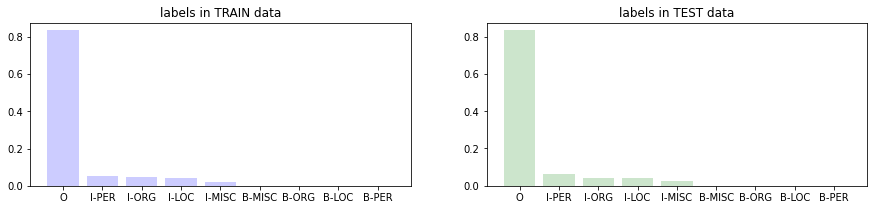

In [19]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,3)

X = range(len(sorted_keys))
axes[0].bar(X, [train_num_by_tags[key]/num_all_train_tags for key in sorted_keys], alpha=0.2, color='blue')
axes[0].set_xticks(X, sorted_keys)
axes[0].set_title("labels in TRAIN data")

axes[1].bar(X, [test_num_by_tags[key]/num_all_test_tags for key in sorted_keys], alpha=0.2, color='green')
axes[1].set_xticks(X, sorted_keys)
axes[1].set_title("labels in TEST data")

plt.show()

In [20]:
print("Number of tags in train data: ", train_num_by_tags)
print("Number of tags in test  data: ", test_num_by_tags)

Number of tags in train data:  {'B-ORG': 24, 'I-LOC': 8286, 'I-ORG': 10001, 'I-MISC': 4556, 'I-PER': 11128, 'O': 169578, 'B-MISC': 37, 'B-LOC': 11, 'B-PER': 0}
Number of tags in test  data:  {'B-ORG': 0, 'I-LOC': 2094, 'I-ORG': 2092, 'I-MISC': 1264, 'I-PER': 3149, 'O': 42759, 'B-MISC': 4, 'B-LOC': 0, 'B-PER': 0}


In [21]:
# Conclusion: number of tags distribution is near the same in train and test data, 
# but train data consists more neighors entities e.g. [I-LOC, I-LOC, B-LOC, I-LOC]

### Print values of entities in train data

In [22]:
entities_by_types = {}
for i, (sentence, labels) in enumerate(zip(train_data["sentences"], train_data["labels_per_sent"])):
    ner_info = get_ner(sentence, labels)
    for ent in ner_info["ents"]:
        
        if ent["label"] not in  entities_by_types: 
            entities_by_types[ent["label"]] = []
        entities_by_types[ent["label"]].append(ner_info["text"][ent["start"]:ent["end"]])

In [23]:
counter_by_types = {}
for ner_type in entities_by_types:
    if ner_type not in counter_by_types: counter_by_types[ner_type]=Counter()
    
    for ner_value in entities_by_types[ner_type]:
        counter_by_types[ner_type][ner_value]+=1
        
for ner_type in entities_by_types:
    print(f"ner type = {ner_type}: ")
    
    print(counter_by_types[ner_type].most_common(20))
    print()

ner type = ORG: 
[('Reuters', 73), ('U.N.', 35), ('NEW YORK', 30), ('CHICAGO', 30), ('PUK', 25), ('OSCE', 25), ('EU', 22), ('NATO', 22), ('European Union', 20), ('Interfax', 18), ('Ajax', 18), ('KDP', 17), ('BALTIMORE', 17), ('MINNESOTA', 17), ('BOSTON', 16), ('DETROIT', 16), ('KANSAS CITY', 16), ('SEATTLE', 16), ('CINCINNATI', 16), ('Marseille', 16)]

ner type = MISC: 
[('Russian', 90), ('German', 76), ('British', 72), ('French', 55), ('Dutch', 50), ('Israeli', 48), ('GMT', 45), ('European', 38), ('English', 37), ('Iraqi', 37), ('Palestinian', 36), ('Olympic', 35), ('Australian', 34), ('Moslem', 31), ('Italian', 28), ('Japanese', 26), ('Republican', 26), ('Chinese', 25), ('World Cup', 24), ('American', 24)]

ner type = LOC: 
[('U.S.', 291), ('Germany', 141), ('Britain', 130), ('Australia', 129), ('France', 121), ('England', 121), ('Spain', 110), ('Italy', 98), ('LONDON', 92), ('China', 91), ('Russia', 88), ('Japan', 87), ('Pakistan', 83), ('Sweden', 81), ('Belgium', 71), ('Iraq', 68),

In [24]:
print("Number of entities in train data:")
for ner_type in entities_by_types:
    print(f"The tag '{ner_type}' has {len(entities_by_types[ner_type])} samples")

Number of entities in train data:
The tag 'ORG' has 6112 samples
The tag 'MISC' has 3187 samples
The tag 'LOC' has 6938 samples
The tag 'PER' has 6355 samples


### Lengths distribution

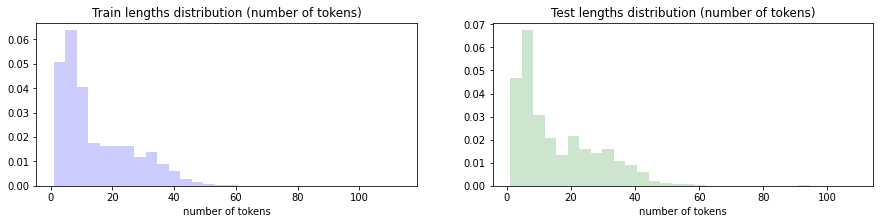

Lengths of sentence in TRAIN data: min = 1, max = 113, mean = 14.501887329962253
Lengths of sentence in TEST  data: min = 1, max = 109, mean = 15.803692307692307


In [25]:
lens_of_train_data, lens_of_test_data = [len(t) for t in train_data["sentences"]], [len(t) for t in test_data["sentences"]] 

fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,3)
axes[0].hist(lens_of_train_data, alpha=0.2, color='blue', bins = 30, density=True)
axes[0].set_xlabel("number of tokens")
axes[0].set_title("Train lengths distribution (number of tokens)")
axes[1].hist(lens_of_test_data, alpha=0.2, color='green', bins = 30, density=True)
axes[1].set_xlabel("number of tokens")
axes[1].set_title("Test lengths distribution (number of tokens)")
plt.show()

min_train, max_train, mean_train = min(lens_of_train_data), max(lens_of_train_data), sum(lens_of_train_data)/len(lens_of_train_data)
print(f"Lengths of sentence in TRAIN data: min = {min_train}, max = {max_train}, mean = {mean_train}")

min_test, max_test, mean_test = min(lens_of_test_data), max(lens_of_test_data), sum(lens_of_test_data)/len(lens_of_test_data)
print(f"Lengths of sentence in TEST  data: min = {min_test}, max = {max_test}, mean = {mean_test}")

In [26]:
print([t for t in train_data['sentences'] if len(t)<14][1:5])
print([t for t in train_data['labels_per_sent'] if len(t)<14][1:5])

[['Peter', 'Blackburn'], ['BRUSSELS', '1996-08-22'], ['.'], ['Only', 'France', 'and', 'Britain', 'backed', 'Fischler', "'s", 'proposal', '.']]
[['I-PER', 'I-PER'], ['I-LOC', 'O'], ['O'], ['O', 'I-LOC', 'O', 'I-LOC', 'O', 'I-PER', 'O', 'O', 'O']]


In [27]:
### Conclusion: if we treat each sentence as a training sample we would face on with problem of 
### lack of a context information (example - ['Peter', 'Blackburn'])
### We need to use chunks that consists from many sentences

# Dataset and tokenizer

In [28]:
model_name = "microsoft/deberta-large" 
tokenizer = DebertaTokenizerFast.from_pretrained(model_name, add_prefix_space=True)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475 [00:00<?, ?B/s]

In [29]:
ind_to_label = {i:v for i, v in enumerate(sorted_keys)}
label_to_ind = {label:i for i, label in ind_to_label.items()}

In [30]:
class NERDataset(Dataset):

    def __init__(self, data, tokenizer, max_length, tag_first_token, label_to_ind):
        
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length
        self.tag_first_token = tag_first_token
        self.label_to_ind = label_to_ind

    def __getitem__(self, index):
        
        sentence = self.data["sentences"][index]
        encoded_sentence = self.tokenizer(sentence,
                                          truncation=True,
                                          max_length=self.max_length, 
                                          is_split_into_words=True)
        if "labels_per_sent" in self.data:
            labels_per_sent = self.data["labels_per_sent"][index] 
            
            labels = []
            prev_word_id = None
            for word_ind in encoded_sentence.word_ids():
                
                if word_ind is None:
                    labels.append(-100)
                else:
                    if self.tag_first_token and word_ind==prev_word_ind:
                        labels.append(-100)
                    else:
                        labels.append(self.label_to_ind[labels_per_sent[word_ind]])
                    
                prev_word_ind = word_ind
                
            encoded_sentence.update({"labels": labels})
        
        return encoded_sentence
                
    def __len__(self):
        return len(self.data["sentences"])


In [31]:
### tokenized text length vs chunk size
### chunk size - how many sentences we will join in one traning sample

In [32]:
chunk_sizes = []
mean_lengths = []
max_lengths = []
for chunk_size in range(1, 20, 2):
    chunked_train_data = chunk_documents(documents=train_documents, chunk_size=chunk_size)
    lengths_of_tok_texts = [len(tokenizer.tokenize(s, is_split_into_words=True, add_special_tokens=True)) for s in chunked_train_data["sentences"]]
    
    chunk_sizes.append(chunk_size)
    mean_lengths.append(sum(lengths_of_tok_texts)/len(lengths_of_tok_texts))
    max_lengths.append(max(lengths_of_tok_texts))

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


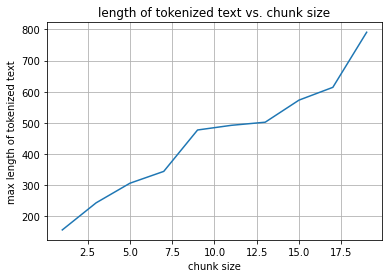

In [33]:
plt.plot(chunk_sizes, max_lengths)
plt.grid()
plt.xlabel("chunk size")
plt.ylabel("max length of tokenized text")
plt.title("length of tokenized text vs. chunk size")
plt.show()

In [34]:
print(*zip(chunk_sizes, max_lengths))

(1, 156) (3, 243) (5, 306) (7, 344) (9, 477) (11, 492) (13, 502) (15, 573) (17, 614) (19, 791)


In [35]:
### Choice chunk size = 13 => max_length= 512
chunk_size = 13
max_length = 512

# Train/test model

### Data preparation

In [36]:
train_ch_data = chunk_documents(documents=train_documents, chunk_size=chunk_size)

In [37]:
# Split train data to train_dataset, val_dataset. 
train_index, val_index = train_test_split(range(len(train_ch_data["sentences"])), test_size=0.2, random_state=42)

In [38]:
val_ch_data = {"sentences":[train_ch_data["sentences"][i] for i in val_index], 
               "labels_per_sent":[train_ch_data["labels_per_sent"][i] for i in val_index]}

train_ch_data = {"sentences":[train_ch_data["sentences"][i] for i in train_index], 
                 "labels_per_sent":[train_ch_data["labels_per_sent"][i] for i in train_index]}

In [39]:
val_dataset = NERDataset(data=val_ch_data, tokenizer=tokenizer, max_length=max_length, tag_first_token=True, label_to_ind =label_to_ind)
train_dataset = NERDataset(data=train_ch_data, tokenizer=tokenizer, max_length=max_length, tag_first_token=True, label_to_ind =label_to_ind)

### Train model

In [40]:
config = AutoConfig.from_pretrained(model_name)
config.update({"id2label": ind_to_label})
config.update({"label2id": label_to_ind})

In [41]:
def get_label(ind):
    if ind == -100:
        return "UNK"
    return ind_to_label[ind]

v_get_label = np.vectorize(get_label)
    
def get_predictions_targets_labels(logits, targets):
    
    predictions = v_get_label(np.argmax(logits, axis=2))
    targets = v_get_label(targets)
    
    
    filtered_predictions = []
    filtered_targets = []
    
    for pred_sentence, target_sentence in zip(predictions, targets):

        filtered_pairs = [[p,t] for p,t in zip(pred_sentence, target_sentence) if t!="UNK"]
        filtered_prediction = [p[0] for p in filtered_pairs]
        filtered_target = [p[1] for p in filtered_pairs]

        filtered_predictions.append(filtered_prediction)
        filtered_targets.append(filtered_target)
    
    return filtered_predictions, filtered_targets


# F1 scores for each type of entity that are based on 'strict' mode (sequences have to matcth strictly)
def compute_metrics(eval_pred):
    logits, targets = eval_pred
    filtered_predictions, filtered_targets = get_predictions_targets_labels(logits, targets)
    result = classification_report(y_true = filtered_targets, 
                                   y_pred=filtered_predictions,
                                   output_dict=True, 
                                   mode="strict", 
                                   scheme=IOB1)
    return {f"F1_{key}":result[key]["f1-score"] for key in result}


In [42]:
path_saved_model = "./saved_model"

collator = DataCollatorForTokenClassification(tokenizer = tokenizer, padding = "longest")
model = AutoModelForTokenClassification.from_pretrained(model_name, config=config)
args = TrainingArguments(report_to="none",
                        output_dir=f"checkpoints",
                        evaluation_strategy = "epoch",
                        save_strategy   = "epoch",
                        save_total_limit = 2,
                        metric_for_best_model = "loss",
                        greater_is_better = False,
                        load_best_model_at_end = True,

                        fp16 = True,
                        logging_strategy = "epoch",
                        learning_rate = 5e-5,
                        warmup_ratio = 0.1,
                        per_device_train_batch_size = 2,
                        per_device_eval_batch_size = 2,
                        num_train_epochs = 10,
                        weight_decay = 0.01,
                        gradient_accumulation_steps = 16,
                        max_grad_norm  = 1.0, 
                        group_by_length =True,
                        seed = 42,

                        label_names = ["labels"])

trainer = Trainer(model,
                  args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  data_collator=collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics
                  )

trainer.train()

tokenizer.save_pretrained(path_saved_model)
model.save_pretrained(path_saved_model)


# del model, tokenizer
# gc.collect()

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaForTokenClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-large and are newly initi

Epoch,Training Loss,Validation Loss,F1 Loc,F1 Misc,F1 Org,F1 Per,F1 Micro avg,F1 Macro avg,F1 Weighted avg
0,0.729000,0.080734,0.912927,0.746617,0.851211,0.963203,0.884695,0.868490,0.886867
1,0.054300,0.046693,0.956229,0.869878,0.915571,0.968728,0.937264,0.927601,0.936592
2,0.029300,0.039536,0.967285,0.910230,0.934227,0.971715,0.951785,0.945864,0.951662
3,0.016100,0.037628,0.968919,0.910230,0.945607,0.968940,0.954318,0.948424,0.954160
4,0.010700,0.037774,0.970210,0.912065,0.950462,0.970609,0.956531,0.950837,0.956525
5,0.007900,0.039385,0.969409,0.917007,0.943286,0.971388,0.955445,0.950272,0.955494
6,0.006100,0.039896,0.969697,0.914169,0.944468,0.972451,0.955706,0.950196,0.955750
7,0.004800,0.041359,0.970847,0.922656,0.945652,0.971408,0.957400,0.952641,0.957394
8,0.003700,0.041986,0.971817,0.924232,0.946444,0.972143,0.958333,0.953659,0.958344
9,0.003000,0.042532,0.971467,0.923497,0.946444,0.971429,0.957908,0.953209,0.957915


***** Running Evaluation *****
  Num examples = 297
  Batch size = 2
Saving model checkpoint to checkpoints/checkpoint-37
Configuration saved in checkpoints/checkpoint-37/config.json
Model weights saved in checkpoints/checkpoint-37/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-37/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-37/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 297
  Batch size = 2
Saving model checkpoint to checkpoints/checkpoint-74
Configuration saved in checkpoints/checkpoint-74/config.json
Model weights saved in checkpoints/checkpoint-74/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-74/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-74/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 297
  Batch size = 2
Saving model checkpoint to checkpoints/checkpoint-111
Configuration saved in checkpoints/checkpoint-111/config.json

### Model validation 

In [43]:
# print VALIDATION performance report for the best model
val_outputs = trainer.predict(val_dataset)
val_predictions = val_outputs.predictions
val_targets = val_outputs.label_ids
val_f_pedictions, val_f_targets = get_predictions_targets_labels(logits=val_predictions, targets=val_targets)

print("Classification report for VALIDATION data:")
print()
print(classification_report(y_true=val_f_targets, 
                            y_pred=val_f_pedictions, 
                            digits=4, 
                            mode="strict", 
                            scheme=IOB1))

***** Running Prediction *****
  Num examples = 297
  Batch size = 2


Classification report for VALIDATION data:

              precision    recall  f1-score   support

         LOC     0.9663    0.9715    0.9689      1476
        MISC     0.9356    0.8862    0.9102       738
         ORG     0.9385    0.9528    0.9456      1186
         PER     0.9728    0.9651    0.9689      1406

   micro avg     0.9567    0.9519    0.9543      4806
   macro avg     0.9533    0.9439    0.9484      4806
weighted avg     0.9566    0.9519    0.9542      4806



In [44]:
# VALIDATION confusion matrix by tags
cnf_matrix_val = confusion_matrix(y_true = sum(val_f_targets,[]), y_pred=sum(val_f_pedictions, []), labels = sorted_keys)
cnf_matrix_val = {sorted_keys[i]:cnf_matrix_val[:,i] for i,k in enumerate(sorted_keys)}

cnf_pd_val = pd.DataFrame(data=cnf_matrix_val)
cnf_pd_val.index = sorted_keys

print("Confusion matrix by tags for VALIDATION data:")
print()
cnf_pd_val

Confusion matrix by tags for VALIDATION data:



,O,I-PER,I-ORG,I-LOC,I-MISC,B-MISC,B-ORG,B-LOC,B-PER
O,33314,14,34,12,18,0,0,0,0
I-PER,5,2293,11,5,4,0,0,0,0
I-ORG,19,8,1823,20,11,0,0,0,0
I-LOC,5,2,32,1664,9,0,0,0,0
I-MISC,34,7,17,15,893,0,0,0,0
B-MISC,0,0,0,0,11,3,0,0,0
B-ORG,1,0,3,1,0,0,0,0,0
B-LOC,0,0,0,2,0,0,0,0,0
B-PER,0,9,0,0,0,0,0,0,0


In [45]:
print("Classification report by tags for VALIDATION data:")
print()
print(sk_classification_report(y_true = sum(val_f_targets,[]), 
                               y_pred=sum(val_f_pedictions, []), 
                               labels = sorted_keys, 
                               zero_division=1))

Classification report by tags for VALIDATION data:

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     33392
       I-PER       0.98      0.99      0.99      2318
       I-ORG       0.95      0.97      0.96      1881
       I-LOC       0.97      0.97      0.97      1712
      I-MISC       0.94      0.92      0.93       966
      B-MISC       1.00      0.21      0.35        14
       B-ORG       1.00      0.00      0.00         5
       B-LOC       1.00      0.00      0.00         2
       B-PER       1.00      0.00      0.00         9

    accuracy                           0.99     40299
   macro avg       0.98      0.56      0.58     40299
weighted avg       0.99      0.99      0.99     40299



### Evaluate metrics on test data

In [46]:
# print TEST performance report for the best model
test_ch_data = chunk_documents(documents=test_documents, chunk_size=chunk_size)
test_dataset = NERDataset(data=test_ch_data, 
                          tokenizer=tokenizer, 
                          max_length=512, 
                          tag_first_token=True, label_to_ind=label_to_ind)
test_outputs = trainer.predict(test_dataset)
test_predictions = test_outputs.predictions
test_targets = test_outputs.label_ids
test_f_pedictions, test_f_targets = get_predictions_targets_labels(logits=test_predictions, targets=test_targets)

print("Confusion matrix for TEST data:")
print()
print(classification_report(y_true=test_f_targets, 
                            y_pred=test_f_pedictions, 
                            digits=4, 
                            mode="strict", 
                            scheme=IOB1))

***** Running Prediction *****
  Num examples = 345
  Batch size = 2


Confusion matrix for TEST data:

              precision    recall  f1-score   support

         LOC     0.9724    0.9777    0.9750      1837
        MISC     0.9038    0.8970    0.9004       922
         ORG     0.9542    0.9627    0.9584      1341
         PER     0.9770    0.9787    0.9779      1827

   micro avg     0.9591    0.9620    0.9606      5927
   macro avg     0.9519    0.9540    0.9529      5927
weighted avg     0.9590    0.9620    0.9605      5927



In [47]:
# TEST confusion matrix by tags
cnf_matrix_test = confusion_matrix(y_true = sum(test_f_targets,[]), y_pred=sum(test_f_pedictions, []), labels = sorted_keys)
cnf_matrix_test = {sorted_keys[i]:cnf_matrix_test[:,i] for i,k in enumerate(sorted_keys)}

cnf_pd_test = pd.DataFrame(data=cnf_matrix_test)
cnf_pd_test.index = sorted_keys

print("Confusion matrix by tags for TEST data:")
print()
cnf_pd_test

Confusion matrix by tags for TEST data:



,O,I-PER,I-ORG,I-LOC,I-MISC,B-MISC,B-ORG,B-LOC,B-PER
O,42619,13,28,10,33,0,0,0,0
I-PER,8,3089,4,2,4,0,0,0,0
I-ORG,3,6,2025,21,37,0,0,0,0
I-LOC,2,2,14,2060,10,0,0,0,0
I-MISC,40,7,19,19,1171,0,0,0,0
B-MISC,0,0,0,1,7,4,0,0,0
B-ORG,0,0,0,0,0,0,0,0,0
B-LOC,0,0,0,6,0,0,0,0,0
B-PER,0,10,0,0,0,0,0,0,0


In [48]:
print("Classification report by tags for TEST data:")
print()
print(sk_classification_report(y_true = sum(test_f_targets,[]), 
                               y_pred=sum(test_f_pedictions, []), 
                               labels = sorted_keys, 
                               zero_division=1))

Classification report by tags for TEST data:

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     42703
       I-PER       0.99      0.99      0.99      3107
       I-ORG       0.97      0.97      0.97      2092
       I-LOC       0.97      0.99      0.98      2088
      I-MISC       0.93      0.93      0.93      1256
      B-MISC       1.00      0.33      0.50        12
       B-ORG       1.00      1.00      1.00         0
       B-LOC       1.00      0.00      0.00         6
       B-PER       1.00      0.00      0.00        10

   micro avg       0.99      0.99      0.99     51274
   macro avg       0.98      0.69      0.71     51274
weighted avg       0.99      0.99      0.99     51274



In [49]:
### Conclusion: the most of mispredictions between ("O", "I-MISK"), (I-MISC, I-ORG),(I-MISC, I-LOC)
### We have a few B-YYY tags, that is why the model can't predict them

### Analyse prediction errors

In [50]:
def convert_tokens_to_words(sentences, tokenizer, logits, ind_to_label, max_length):
    
    predictions_tokens = v_get_label(np.argmax(logits, axis=2))
    predictions = []
    
    for i, sentence in enumerate(sentences):
        
        preds_of_sent = ["NONE"]*len(sentence)
        encoded_sentence = tokenizer(sentence, 
                                     truncation=True, 
                                     max_length=logits.shape[1], 
                                     is_split_into_words=True)
        
        for j, word_id in enumerate(encoded_sentence.word_ids()):
            if word_id is not None:
                if preds_of_sent[word_id]=="NONE": 
                    preds_of_sent[word_id]=predictions_tokens[i][j]
                    
        predictions.append(preds_of_sent)
    return predictions

test_word_tags = convert_tokens_to_words(sentences=test_ch_data["sentences"], 
                                         tokenizer=tokenizer, 
                                         logits=test_predictions, 
                                         ind_to_label=ind_to_label, 
                                         max_length=max_length)

In [51]:
# target = O, prediction = I-MISC errors:
window = 4
count = 0
for predictions, targets, sentence in zip(test_word_tags, test_ch_data["labels_per_sent"], test_ch_data["sentences"]):
    for i, (prediction, target, word) in enumerate(zip(predictions, targets,sentence )):
        if target == "O" and prediction == "I-MISC":
            start = 0 if i-window < 0 else i-window
            print("targets:")
            show_ner(words = sentence[start: i+window], tags=targets[start: i+window])
            print("predictions:")
            show_ner(words = sentence[start: i+window], tags=predictions[start: i+window])
            print("="*100)
            count += 1
    if count > 5: break


targets:


predictions:


targets:


predictions:


targets:


predictions:


targets:


predictions:


targets:


predictions:


targets:


predictions:


In [52]:
### Conclusion: maybe we have not labeled data?

# Further ideas

In [53]:
# 1. Use large models (e.g. deberta-xlarge)
# 2. Use LSTM or CRF head for token classification. This approach can help to increase performance 
#    especially for long entinites.
# 3. Analyse tags and correct them. Probably there are not labeled data e.g. MISC.
# 4. Use additional features like POS (if possible).